# Reproducing Fig 2

In [69]:
%load_ext autoreload
%autoreload 2
import pens
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')
pens.set_style()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
path = '../data/gmt_MCruns_ensemble_full_LMRv2.1.nc'
LMR = pens.EnsembleTS().load_nc(path, var='gmt')
LMR.label = 'LMR v2.1'
LMR.value_name = 'GMST'
LMR.value_unit = '\N{DEGREE SIGN}C'
LMR.time_name = 'Time'
LMR.time_unit = 'yrs'
LMR.plot_qs()

In [3]:
df = pd.read_table('../data/PMIP3_GMST.txt')
# create a new pandas.DataFrame to store the processed data
dfn = df.copy()

# remove the data columns for CESM and GISS ensemble members
for i in range(10):
    dfn = dfn.drop([f'CESM_member_{i+1}'], axis=1)
    
dfn = dfn.drop(['GISS-E2-R_r1i1p127.1'], axis=1)
dfn = dfn.drop(['GISS-E2-R_r1i1p127'], axis=1)
dfn = dfn.drop(['GISS-E2-R_r1i1p121'], axis=1)

# calculate the ensemble mean for CESM and GISS, and add the results into the table
dfn['CESM'] = df[[
    'CESM_member_1',
    'CESM_member_2',
    'CESM_member_3',
    'CESM_member_4',
    'CESM_member_5',
    'CESM_member_6',
    'CESM_member_7',
    'CESM_member_8',
    'CESM_member_9',
    'CESM_member_10',
]].mean(axis=1)

dfn['GISS'] = df[[
    'GISS-E2-R_r1i1p127.1',   
    'GISS-E2-R_r1i1p127',
    'GISS-E2-R_r1i1p121',
]].mean(axis=1)

# display the processed data
dfn

,Year,bcc_csm1_1,CCSM4,FGOALS_gl,FGOALS_s2,IPSL_CM5A_LR,MPI_ESM_P,CSIRO,HadCM3,CESM,GISS
0,850,-0.570693,-0.431830,NaN,-0.620995,-0.475963,-0.170230,NaN,-0.620517,0.049553,0.127429
1,851,-0.698903,-0.411177,NaN,-0.753160,-0.742970,-0.303124,-0.398695,-0.553043,0.193858,0.138796
2,852,-0.575440,-0.404802,NaN,-0.743508,-0.758939,-0.422623,-0.406343,-0.560791,0.185033,0.098170
3,853,-0.724757,-0.552719,NaN,-0.869331,-0.746460,-0.335177,-0.353557,-0.438949,0.120470,-0.054552
4,854,-0.724328,-0.734938,NaN,-0.826238,-0.684093,-0.650792,-0.416140,-0.812194,-0.081349,-0.407169
...,...,...,...,...,...,...,...,...,...,...,...
1161,2011,1.013544,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1162,2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1163,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1164,2014,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


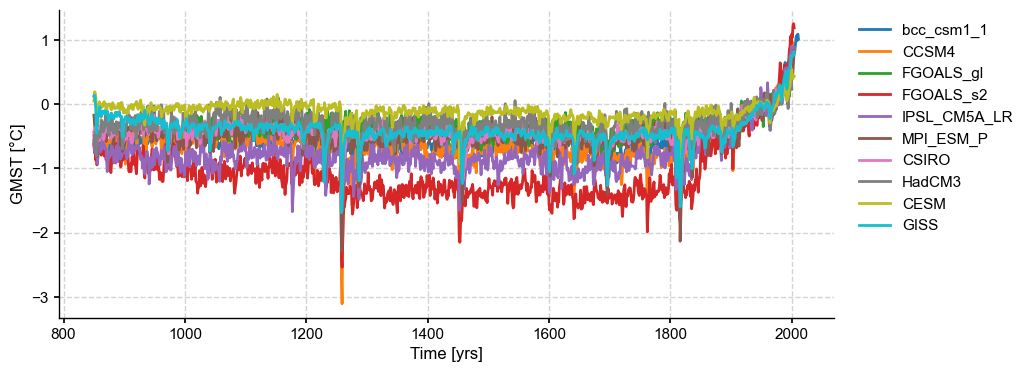

In [4]:
# store each pyleoclim.Series() object into a dictionary and plot
import pyleoclim as pyleo
ts_dict = {}
for name in dfn.columns[1:]:
    ts_dict[name] = pyleo.Series(
        time=dfn['Year'].values,  # the time axis
        value=dfn[name].values,   # the value axis
        label=name,                  # optional metadata: the nickname of the series
        time_name='Time',            # optional metadata: the name of the time axis
        time_unit='yrs',             # optional metadata: the unit of the time axis
        value_name='GMST',     # optional metadata: the name of the value axis
        value_unit='\N{DEGREE SIGN}C',              # optional metadata: the unit of the value axis
    )

ts_list = [v for k, v in ts_dict.items()]  # a pythonic way to convert the pyleo.Series items in the dictionary to a list
ms_pmip = pyleo.MultipleSeries(ts_list)
fig, ax = ms_pmip.plot(lgd_kwargs={
        'bbox_to_anchor': (1.25, 1),  # move the legend to the right side
    })

Next we compute the Mean Squared Error between the target series (CCSM4) and all possible trajectories within the ensemble, then find a trajectory that mimimizes it:

(<Figure size 1200x400 with 1 Axes>,
 <AxesSubplot:xlabel='Time [yrs]', ylabel='GMST [°C]'>)

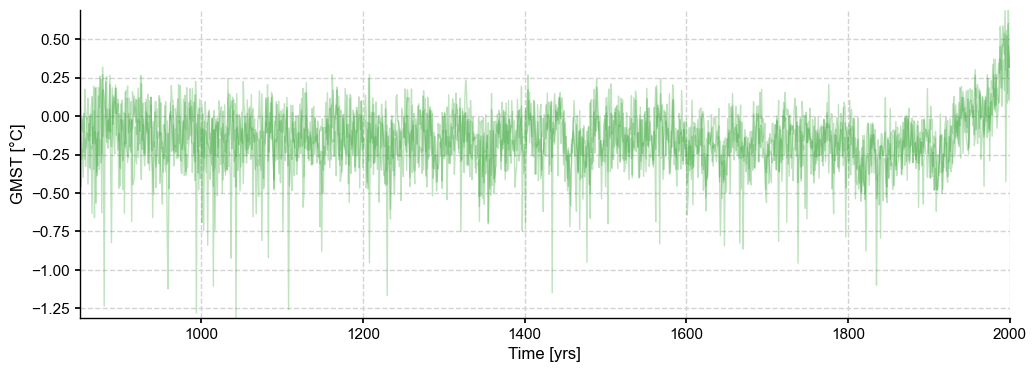

In [5]:
ts = ts_list[7] # select HadCM3
common_time = [850,2000]
lmr_slice = LMR.slice(common_time)
HadCM3 = ts.slice(common_time)
path_nearest = lmr_slice.sample_nearest(HadCM3.value, metric='MSE')
dist = path_nearest.distance  # extract distance metric
#
ens_unif = lmr_slice.random_paths(model='unif',p=3, seed=44)
ens_unif.plot(color='tab:green',alpha=0.3)

Let's get the HDI score of each of these. 

In [26]:
import numpy as np
ns = ens_unif.nEns
hdi_score = np.zeros((ns))
for k in range(ns):
    hdi_score[k], _ = lmr_slice.hdi_score(y=ens_unif.value[:,k])

## Spectral analysis

In [6]:
es_orig = lmr_slice.to_pyleo()  
PSD_orig = es_orig.spectral(method='mtm',settings={'standardize':False}) # this generates a MultiplePSD object

Performing spectral analysis on individual series: 100%|██████████| 2000/2000 [01:11<00:00, 27.93it/s]


In [71]:
PSD_orig_aa = PSD_orig.anti_alias()

In [7]:
ps_rnd = lmr_slice.random_paths(model='unif',p=LMR.nEns, seed=2333)
es_rnd = ps_rnd.to_pyleo() # resample while preserving ensemble size
PSD_rnd = es_rnd.spectral(method='mtm',settings={'standardize':False})

Performing spectral analysis on individual series: 100%|██████████| 2000/2000 [01:12<00:00, 27.48it/s]


In [73]:
PSD_rnd_aa = PSD_rnd.anti_alias()

In [8]:
percent = lmr_slice.trace_rank(y=HadCM3.value)

## Making the figure

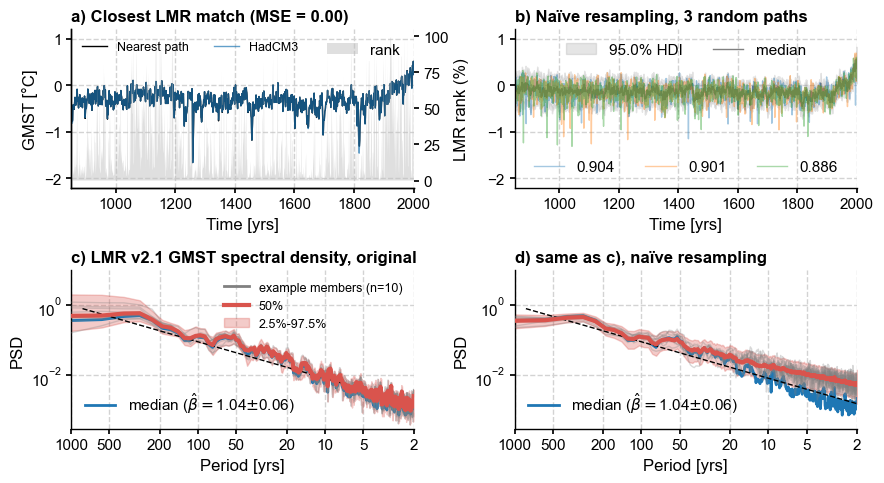

In [83]:
fig, axs = plt.subplots(2,2,figsize=(9,5))
axs = axs.flatten()

# a) closest match
ax0 = axs[0].twinx()
ax0.grid(False)
ax0.fill_between(lmr_slice.time, 0, percent, alpha=0.5, zorder=0,
                 facecolor='silver', label='rank')
ax0.set_ylabel('LMR rank (%)')
path_nearest.plot(ax=axs[0],color='k', label='Nearest path')
ts.plot(ax=axs[0], ylim=(-2.2, 1.2), alpha=0.7, linewidth=1)
axs[0].legend(loc='upper left', ncol=2, fontsize=9,framealpha = 0.9)
axs[0].set_title(f'a) Closest LMR match (MSE = {dist:3.2f})',
                 loc = 'left', fontweight = 'bold')
ax0.legend()
# b) naive resampling 
lmr_slice.plot_hdi(prob=0.95, color='gray',ax=axs[1],title='')
ens_unif.plot(ax=axs[1],alpha=0.4, ylabel='', label = 'duh', legend_kwargs={'show':True})
axs[1].set_title('b) Naïve resampling, 3 random paths',
                 loc = 'left', fontweight = 'bold')
axs[1].set_ylim(axs[0].get_ylim())
# split the legend in 2 parts
h, l = axs[1].get_legend_handles_labels()
l2 = [f'{hdi_score[k]:3.3f}' for k in range(ns)]
legend1 = axs[1].legend(handles=h[:2], loc='upper center', ncol=2)
axs[1].add_artist(legend1)
legend2 = axs[1].legend(handles=h[2:], labels = l2, loc='lower center', ncol=3)

# c) Undisturbed spectra 
ylims = [3e-4,10]
PSD_orig_aa.plot_envelope(ax=axs[2])
axs[2].set_title('c) LMR v2.1 GMST spectral density, original',
                 loc = 'left', fontweight = 'bold')
esm = lmr_slice.get_median() # extract and analyze the ensemble median
esm = esm.to_pyleo(label='median')
esm_spec = esm.spectral(method ='mtm',settings={'standardize':False})
esm_beta = esm_spec.anti_alias().beta_est() # estimate spectral exponent
esm_beta.plot(ax=axs[2], ylim=ylims)
             #lgd_kwargs={'loc':'upper right','fontsize':8})
h, l = axs[2].get_legend_handles_labels()
legend1 = axs[2].legend(handles=h[:3], loc='upper right',fontsize = 9)
axs[2].add_artist(legend1)
legend2 = axs[2].legend(handles=h[3:], loc='lower left')

# d) Resampled spectra
PSD_rnd_aa.plot_envelope(ax=axs[3])
axs[3].set_title('d) same as c), naïve resampling',
                 loc = 'left', fontweight = 'bold')
esm_rnd = ps_rnd.get_median() # extract and analyze the ensemble median
esm_rnd = esm_rnd.to_pyleo(label='median')
esm_rnd_spec = esm_rnd.spectral(method ='mtm',settings={'standardize':False})
esm_rnd_beta = esm_rnd_spec.anti_alias().beta_est() # estimate spectral exponent
esm_rnd_beta.plot(ax=axs[3],ylim=ylims, ylabel='PSD')
h, l = axs[3].get_legend_handles_labels()
axs[3].get_legend().remove()
axs[3].set_xlabel(axs[2].get_xlabel()) # make labels the same
axs[3].legend(handles=h[3:], loc='lower left')
fig.tight_layout()

In [84]:
fig.savefig('../figures/naive_resampling.pdf',dpi=300, bbox_inches='tight')